# Classificador de Imagens de Gatos e Cachorros

Rafael Gurgel

## Introdução

Esse classificador foi desenvolvido conforme solicitado no Bootcamp da DIO. O objetivo é utilizar técnicas de transfer-learning da base do MNIST e aplicar em um outro classificador de imagens.

A base de dados fornecida é pública e pode ser obtida [aqui](https://www.microsoft.com/en-us/download/details.aspx?id=54765)



## Importação das bibliotecas

O classificador foi desenvolvido utilizando as seguintes bibliotecas

In [1]:
import random
import numpy as np
from glob import glob
from pandas import DataFrame, read_csv

import matplotlib.image as img
import matplotlib.pyplot as plt

from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers,metrics, losses
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow import expand_dims
from tensorflow.image import resize

## Importação dos dados

In [2]:
fpath = glob("PetImages/*/*.jpg")
target = ['Dog' in string for string in fpath]
labels = ['Cat', 'Dog']      

images = ImageDataGenerator(validation_split=0.2).flow_from_dataframe(
    dataframe=DataFrame(
        list(zip(fpath,[labels[t] for t in target])),
        columns=["filename", "class"]),
    classes=labels,
    batch_size=32,
    seed=42,
    shuffle=True)

print(f'\033[96mImagens de cães: {sum(target)}')
print(f'\033[96mImagens de gatos: {sum([not(t) for t in target])}')

Found 25000 validated image filenames belonging to 2 classes.
Imagens de cães: 12500
Imagens de gatos: 12500


**Visualizando algumas imagens para verificar a importação**

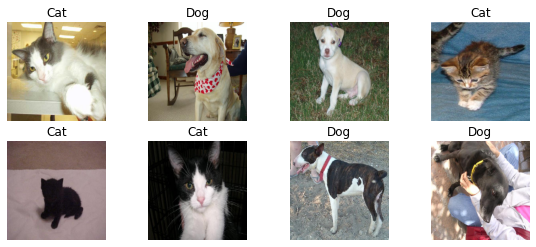

In [3]:
def view(imgs, nrows=2, ncols=4, figsize=(9.7,4), model=None):
    x,y = imgs.next()
    _, hAx = plt.subplots(nrows=nrows, ncols=ncols,figsize=figsize)
    r = random.sample(range(len(y)),len(hAx.flat))   # Random images from batch
    for i,ax in enumerate(hAx.flat):
        plt.sca(ax)
        plt.imshow(x.astype('uint8')[r[i],:,:,:])
        plt.title(list(imgs.class_indices.keys())[y[r[i]].argmax()])
        plt.axis('off')
view(images)

Parecem ok, mas <big><span style="color:red">
**nunca**</span></big> deve-se confiar em dados fornecidos por terceiro.

Nesse caso, foi feito um segundo teste de sanidade, ordenando as imagens por predominancia mais comum de uma determinada cor.

In [4]:
def color_predominance(fn):
    try:
        image = img.imread(fn)
        _,c = np.unique(image.reshape(-1,3), axis=0, return_counts=True)
        color_percentual =c.max()/c.sum()
        return color_percentual
    except Exception:
        return 1

try: # Load pre-computed data
    same_pixels = read_csv("percentual.csv")
except Exception: # Compute data
    same_pixels = [color_predominance(fn) for fn in tqdm(images.filenames)]
    same_pixels = sorted(zip(same_pixels,images.filenames), reverse=True)
    same_pixels = DataFrame(same_pixels, columns=['Percentual','Filename'])
    same_pixels.to_csv('percentual.csv',index=False)

Esse script auxiliou na identificação de algumas imagens atípicas

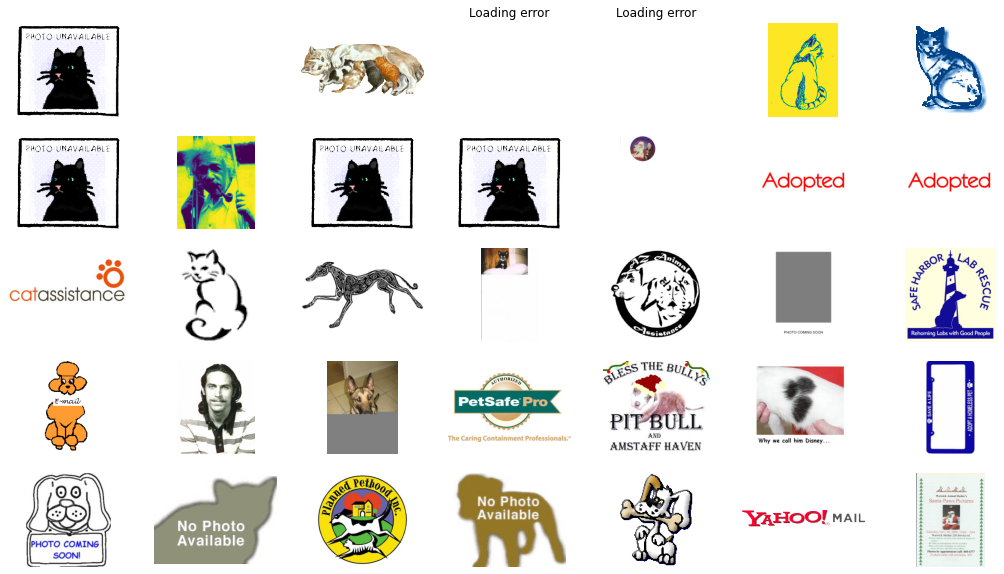

In [5]:
f, ax = plt.subplots(5, 7, figsize=(18,10))
for i,ax in enumerate(ax.flatten(),start=0):
    try:
        color_percentual, fp = same_pixels.iloc[i]
        ax.imshow(plt.imread(fp))
        ax.axis("off")
    except: 
        ax.axis("off")
        ax.set_title(f'Loading error')

Apesar de em uma quantidade muito pequena quando comparadada ao dataset, vamos excluí-las da análise

In [6]:
fpath = same_pixels.loc[35:,'Filename'].to_list()

target = ['Dog' in string for string in fpath]
labels = ['Cat', 'Dog']             # Cat: 0, Dog: 1
    
print(f'\033[96mImagens de cães: {sum(target)}')
print(f'\033[96mImagens de gatos: {sum([not(t) for t in target])}')

Imagens de cães: 12483
Imagens de gatos: 12482


In [7]:
idg = ImageDataGenerator(validation_split=0.2)
train = idg.flow_from_dataframe(
    dataframe=DataFrame(
        list(zip(fpath,[labels[t] for t in target])),
        columns=["filename", "class"]),
    classes=labels,
    class_mode='binary',
    batch_size=32,
    seed=42,
    shuffle=True,
    target_size=(128,128),
    subset='training')

validation = idg.flow_from_dataframe(
    dataframe=DataFrame(
        list(zip(fpath,[labels[t] for t in target])),
        columns=["filename", "class"]),
    classes=labels,
    class_mode='binary',
    batch_size=32,
    seed=42,
    shuffle=True,
    target_size=(128,128),
    subset='validation')

Found 19972 validated image filenames belonging to 2 classes.
Found 4993 validated image filenames belonging to 2 classes.


## Treinamento

Optou-se por utilizar a técnica de Transfer Learning utilizando  a arquitetura da `EFFicientNetB4`. Ela foi selecionada devido o compromisso que possui entre a performance e quantidade de parâmetros. Como possui menos que 100Mb, é possível salvar o modelo final no repositório do Github

In [8]:
enb4 = EfficientNetB4(include_top=False, input_shape=(128,128,3), classes=2)

input = layers.Input(shape=(128,128,3))

x = layers.RandomContrast(factor=0.1, seed=0)(input)
x = layers.RandomFlip(mode='horizontal', seed=1)(x)
x = layers.RandomRotation(factor=0.1, seed=2)(x)
x = layers.RandomZoom(0.1, seed=3)(x)

x = enb4(x)
    
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(rate=0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(rate=0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)   
model = Model(inputs=input, outputs=output)

model.compile(optimizer=Nadam(),
                loss=losses.BinaryCrossentropy(),
                metrics=[metrics.BinaryAccuracy(),
                         metrics.AUC(),
                         metrics.Precision(),
                         metrics.Recall()])

learn_control = EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,
        patience=5,
        verbose=0,
        restore_best_weights=True)

history = model.fit(train, epochs=50,
        validation_data=validation,
        callbacks=[learn_control])
model.save_weights('model_weights.h5')

Epoch 1/50
358/625 [================>.............] - ETA: 2:08 - loss: 0.2365 - binary_accuracy: 0.9042 - auc: 0.9665 - precision: 0.9167 - recall: 0.9011

c:\ProgramData\Anaconda3\envs\cuda\lib\site-packages\PIL\TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 378s 527ms/step - loss: 0.2011 - binary_accuracy: 0.9207 - auc: 0.9754 - precision: 0.9272 - recall: 0.9224 - val_loss: 0.1239 - val_binary_accuracy: 0.9571 - val_auc: 0.9897 - val_precision: 0.9463 - val_recall: 0.9424
Epoch 2/50
625/625 [==============================] - 315s 504ms/step - loss: 0.1263 - binary_accuracy: 0.9531 - auc: 0.9897 - precision: 0.9510 - recall: 0.9608 - val_loss: 0.1443 - val_binary_accuracy: 0.9353 - val_auc: 0.9915 - val_precision: 0.8686 - val_recall: 0.9808
Epoch 3/50
625/625 [==============================] - 311s 498ms/step - loss: 0.1019 - binary_accuracy: 0.9639 - auc: 0.9929 - precision: 0.9618 - recall: 0.9703 - val_loss: 0.0960 - val_binary_accuracy: 0.9660 - val_auc: 0.9945 - val_precision: 0.9408 - val_recall: 0.9730
Epoch 4/50
625/625 [==============================] - 308s 493ms/step - loss: 0.0911 - binary_accuracy: 0.9657 - auc: 0.9943 - precision: 0.9635 - recall: 0.9720 - val_loss: 0.1217 - val_bi

### Resultados

O treino resultou em uma acurária de 97% nos dados de validação, sendo assim um resultado bem satisfatório. O critério para o *early stopping* foi atingido ná época 18, sendo importante para evitar o overfitting do modelo

Um teste extra foi gerado, utilizando uma base quase que exclusivamente de imagens próprias, e algumas consideradas desafiadoras a princípio.

Found 24 validated image filenames.


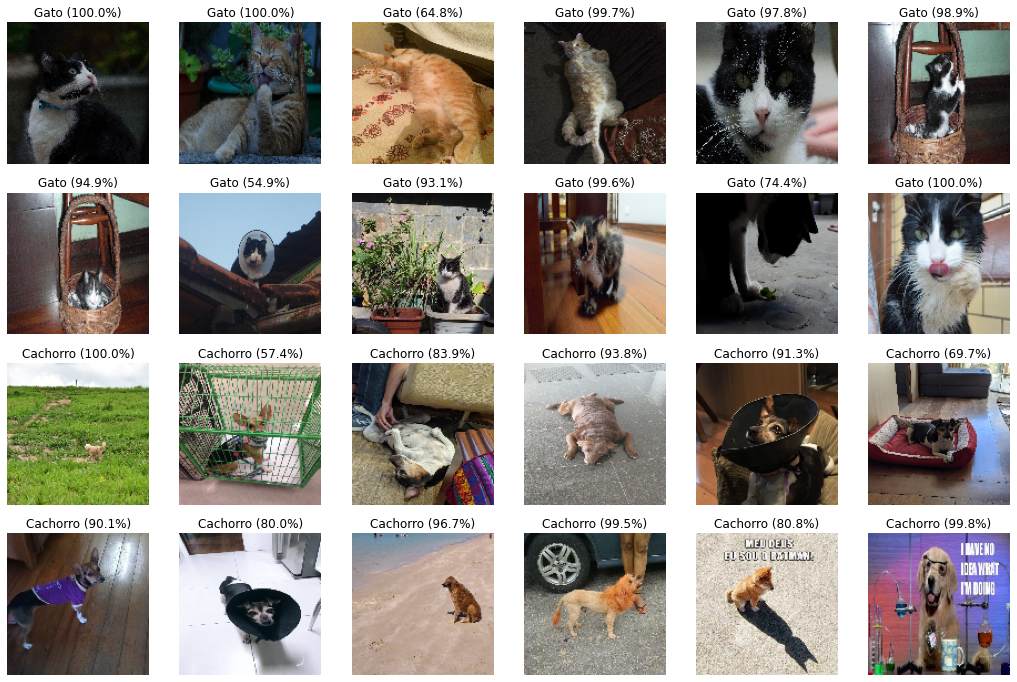

In [14]:
test_path = glob("Real_Test_Data/*.jpg")
X_test = ImageDataGenerator().flow_from_dataframe(
            DataFrame(test_path), class_mode=None, x_col=0,
            target_size=(128,128), shuffle=False).next()

y_test = model.predict(X_test).flatten()

def get_title(val):
    if val<0.5:
        return f'Gato ({1-val:.1%})'
    else:
        return f'Cachorro ({val:.1%})'
    
f, ax = plt.subplots(4, 6, figsize=(18,12))
for i,ax in enumerate(ax.flatten(),start=0):
    ax.imshow(X_test[i]/255)
    ax.set_title(get_title(y_test[i]))
    ax.axis("off")

Esses resultados são bem interessantes. Por exemplo, o uso do colar, ou existência da vegetação ao fundo não alterou a decisão. Além disso, as imagens de silhueta testadas apresentaram o resultado esperado.

Entretanto um ponto interessante é na penúltima foto, de um cachorro, cuja sombra lembrava contornos de gato, e mesmo assim foi identificado corretamente.

Com isso, podemos tentar responder a seguinte pergunta: O catdog é um cachorro ou um gato???

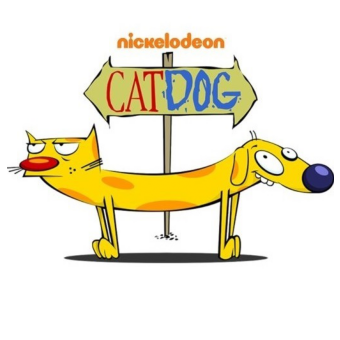

In [15]:
catdog = img.imread('Real_Test_Data/extra/catdog.jpg')
f, ax = plt.subplots(figsize=(6,6))
ax.imshow(catdog/255)
ax.axis("off");
plt.show();

E o resultado é ....

In [16]:
catdog = expand_dims(resize(catdog, (128,128)),0)
print(get_title(model.predict(catdog).flatten()[0]))

Gato (52.7%)


🙀

Mas também significa que é 47,3% 🐶!